In [326]:
import pandas as pd
import numpy as np

import missingno as msno
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import datetime
from dateutil.parser import parse
from sklearn.tree import  DecisionTreeClassifier
import plotly.graph_objects as go
import umap
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import ml_metrics
import pickle
from sklearn.metrics import accuracy_score
import joblib
import json
import sklearn.metrics as metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

In [325]:
Data=pd.read_csv("cleaned_01June2022.csv").drop(columns=["Unnamed: 0"]).fillna("")

In [316]:
# datos númericos
numerical=list(Data.select_dtypes(exclude=["category","object"]).columns)
numerical.remove("Sexo")
numerical.remove('Recibe_sueldo_en_cuenta')


# datos categorical
categorical=list(Data.select_dtypes(include=["category","object"]).columns)+['Sexo','Recibe_sueldo_en_cuenta']
categorical.remove("Target")

In [327]:
for i in categorical:
    Data[i]=Data[i].astype(str)

In [328]:
# Select 1 - Only Gini, corte visual
select_variables_1=['E-F',
 'C-C',
 'D-F',
 'A-K',
 'num_comunicaciones',
 'Length',
 'pref_A-A',
 'Positivo',
 'Recency',
 'A-G',
 'Monto',
 'Periodicity',
 'Frequency',
 'lec_B-B',
 'G-K']

In [329]:
# Select 2 - Criterio Corr Kill
select_variables_2=['E-F',
 'C-C',
 'D-F',
 'A-K',
 'pref_A-A',
 'num_comunicaciones',
 'Length',
 'Sin Info',
 'F-I',
 'Monto',
 'B',
 'lec_B-B',
 'Comuna',
 'Edad',
 'Ciudad',
 'Profesion',
 'Renta',
 'F-H',
 'lec_A-A',
 'Principalidad',
 'A-L',
 'lec_C-D',
 'Estado_civil']

In [323]:
numerical1=list(filter(lambda x:x  in numerical,select_variables_1))
categorical1=list(filter(lambda x:x  in categorical,select_variables_1))

In [324]:
numerical2=list(filter(lambda x:x  in numerical,select_variables_2))
categorical2=list(filter(lambda x:x  in categorical,select_variables_2))

In [270]:
# Preprocesamiento de datos
preprocessing_transformer1 = ColumnTransformer(
    transformers=[('OneHotEncoder', OneHotEncoder(handle_unknown="ignore"),categorical1 ),
        ('MinMax', MinMaxScaler(),numerical1),
    ])

In [271]:
# Preprocesamiento de datos
preprocessing_transformer2 = ColumnTransformer(
    transformers=[('OneHotEncoder', OneHotEncoder(handle_unknown="ignore"),categorical2 ),
        ('MinMax', MinMaxScaler(),numerical2),
    ])

------------------------

# Train, Test Split

In [330]:
X=Data.drop(columns=["Target"])[select_variables_1].copy()

In [331]:
Y=Data["Target"]

In [332]:
enc = OneHotEncoder()
Y = enc.fit_transform(Y[:, np.newaxis]).toarray()

In [333]:
dic={}
to_enc_inv=list(enc.categories_[0])
for i in range(len(to_enc_inv)):
    dic[i]=to_enc_inv[i]

In [334]:
inv_map = {v: k for k, v in dic.items()}

In [336]:
n_features =X.shape[1]
n_classes =Y.shape[1]

In [337]:
# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.5, random_state=2)
minmax=MinMaxScaler()
minmax.fit(X_train)
X_train=minmax.transform(X_train)
X_test=minmax.transform(X_test)

In [277]:
# Sobremuestreo:
#ros=RandomOverSampler(random_state=0) # Random_state=0
# ROS:
#X_train, Y_train=ros.fit_resample(X_train,Y_train)

In [338]:
# Submuestreo:
rus=RandomUnderSampler(random_state=0) # Random_state=0
# ROS:
X_train, Y_train=rus.fit_resample(X_train,Y_train)

In [339]:
model = Sequential()
model.add(Dense(4, input_dim=n_features, activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(4,activation='relu'))

model.add(Dense(n_classes,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

#alfa=0.05
#my_optimizer = SGD(lr = alfa)
#model.compile(optimizer=my_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 4)                 64        
                                                                 
 dense_121 (Dense)           (None, 4)                 20        
                                                                 
 dense_122 (Dense)           (None, 4)                 20        
                                                                 
 dense_123 (Dense)           (None, 74)                370       
                                                                 
Total params: 474
Trainable params: 474
Non-trainable params: 0
_________________________________________________________________


In [340]:
cb = TensorBoard(log_dir='./', histogram_freq=1)
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=20)

In [341]:
history_callback=model.fit(X_train, Y_train, epochs=300, batch_size=10,verbose=1,
validation_data=(X_test, Y_test),
callbacks=[early_stopping_monitor],
#validation_split = 0.1
#callbacks=[cb]
)
scores = model.evaluate(X_test, Y_test)

Epoch 1/300
378/378 [==============================] - 5s 12ms/step - loss: 4.3000 - accuracy: 0.0119 - val_loss: 4.2597 - val_accuracy: 0.0119
Epoch 2/300
378/378 [==============================] - 4s 11ms/step - loss: 4.2259 - accuracy: 0.0159 - val_loss: 4.1074 - val_accuracy: 0.0123
Epoch 3/300
378/378 [==============================] - 4s 10ms/step - loss: 4.1377 - accuracy: 0.0196 - val_loss: 3.9931 - val_accuracy: 0.0266
Epoch 4/300
378/378 [==============================] - 4s 10ms/step - loss: 3.8846 - accuracy: 0.0244 - val_loss: 3.8493 - val_accuracy: 0.0072
Epoch 5/300
378/378 [==============================] - 4s 10ms/step - loss: 3.7927 - accuracy: 0.0249 - val_loss: 3.7850 - val_accuracy: 0.0147
Epoch 6/300
378/378 [==============================] - 4s 10ms/step - loss: 3.7538 - accuracy: 0.0321 - val_loss: 3.7614 - val_accuracy: 0.0128
Epoch 7/300
378/378 [==============================] - 4s 10ms/step - loss: 3.7292 - accuracy: 0.0265 - val_loss: 3.7346 - val_accuracy:

--------------------

In [ ]:
### Para guardar los modelos se hace de la siguiente forma
from tensorflow import keras

# Guardar el Modelo
model.save('my_model_hoy.h5')

# Recrea exactamente el mismo modelo solo desde el archivo
new_model = keras.models.load_model('my_model_hoy.h5')

new_model.summary()

----------------------

In [342]:
scores = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print(scores)

1155/1155 [==============================] - 2s 2ms/step - loss: 2.8936 - accuracy: 0.1845
Test loss: 2.89355731010437
Test accuracy: 0.1845146268606186
[2.89355731010437, 0.1845146268606186]


In [343]:
  ### Genero la predicción con el modelo
y_pred = model.predict(X_test)
y_pred

1155/1155 [==============================] - 2s 1ms/step


array([[1.1342751e-06, 2.7345497e-05, 1.0019576e-04, ..., 3.5878796e-02,
        3.0951548e-02, 3.7375492e-05],
       [2.2774448e-01, 1.9005118e-01, 8.5279778e-02, ..., 2.8178093e-07,
        8.6842242e-11, 2.3386132e-03],
       [1.7188052e-02, 5.0121501e-02, 8.7200694e-02, ..., 5.9790593e-03,
        3.5700456e-03, 2.9893729e-03],
       ...,
       [1.3782644e-03, 3.3623309e-04, 3.0748130e-04, ..., 1.6617205e-02,
        1.2746468e-02, 2.4259748e-02],
       [1.4901448e-06, 3.1599175e-06, 5.9348667e-06, ..., 9.3414083e-02,
        9.2059217e-02, 7.6863600e-04],
       [4.6877913e-02, 3.0688543e-02, 2.7269769e-02, ..., 8.9914107e-04,
        8.0939208e-05, 1.4905515e-02]], dtype=float32)

In [344]:
y_pred_1col = np.argmax(y_pred, axis=1, out=None) 
y_pred_1col

array([44,  0,  2, ..., 59, 71,  7], dtype=int64)

In [345]:
y_pred_1col = pd.DataFrame(y_pred_1col, columns= ['target'])
y_pred_1col

,target
0,44
1,0
2,2
3,71
4,41
...,...
36946,59
36947,8
36948,59
36949,71


In [346]:
y_test_1col = pd.DataFrame(enc.inverse_transform(Y_test), columns= ['target']).replace(inv_map)
y_test_1col

,target
0,16
1,0
2,8
3,15
4,57
...,...
36946,57
36947,0
36948,15
36949,55


In [347]:
print(classification_report(y_pred_1col,y_test_1col))

              precision    recall  f1-score   support

           0       0.58      0.69      0.63      5217
           1       0.22      0.09      0.13      1873
           2       0.31      0.05      0.08      2090
           3       0.00      0.00      0.00         0
           4       0.56      0.05      0.09      1155
           5       0.00      0.00      0.00         0
           6       0.12      0.02      0.03      1184
           7       0.27      0.01      0.02      2656
           8       0.11      0.18      0.13      1368
           9       0.34      0.12      0.18       717
          10       0.21      0.02      0.04       871
          11       0.14      0.13      0.14       326
          12       0.17      0.03      0.06       690
          13       0.00      0.00      0.00         0
          14       0.03      0.05      0.04        37
          15       0.00      0.00      0.00         0
          16       0.02      0.05      0.03        57
          17       0.00    

In [348]:
history_dict=history_callback.history

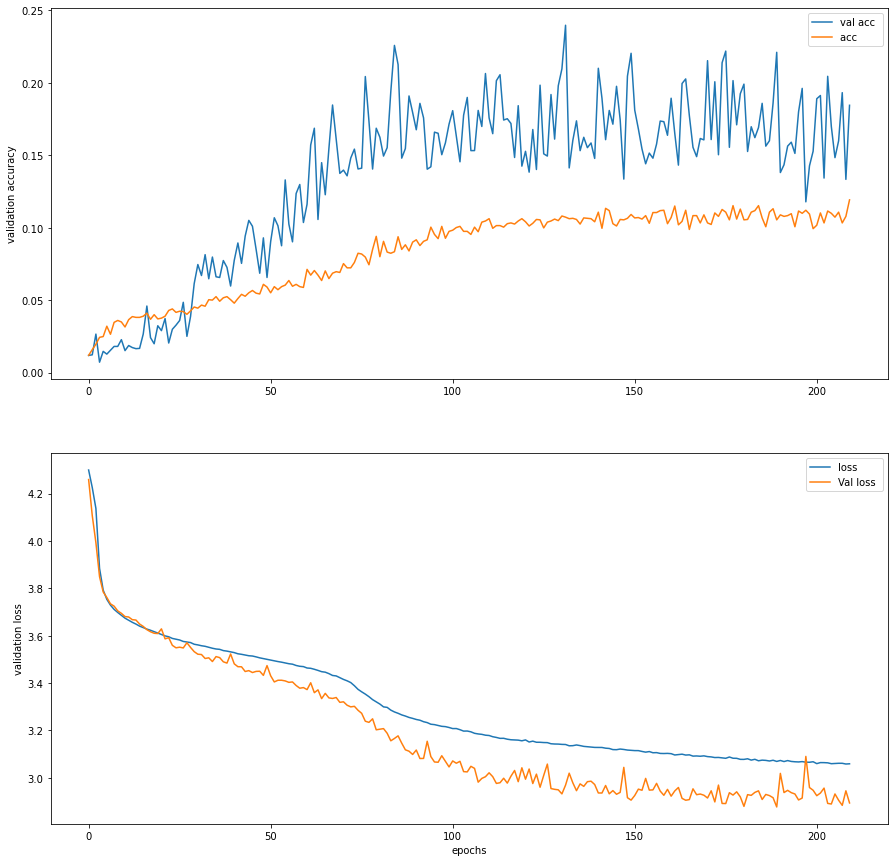

In [349]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 15))

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']
ax1.plot(val_accuracy, label="val acc ")
ax1.plot(accuracy, label="acc ")

ax2.plot(loss, label= "loss ")
ax2.plot(val_loss, label= "Val loss ")
    
ax1.set_ylabel('validation accuracy')
ax2.set_ylabel('validation loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend();

<function matplotlib.pyplot.show(close=None, block=None)>

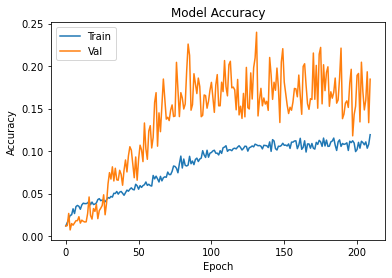

In [350]:
# Visualize the model's accuracy
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show

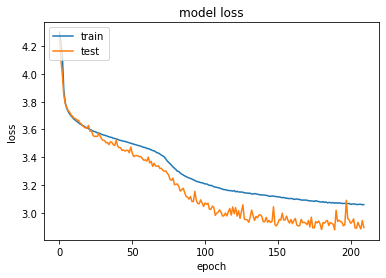

In [351]:
# summarize history for loss
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [353]:
Ypred_map=y_pred_1col["target"].replace(dic).apply( lambda x: x.split(" "))
Ytest_map=y_test_1col["target"].replace(dic).apply( lambda x: x.split(" "))
ml_metrics.mapk(Ytest_map, Ypred_map, 5)

0.6200922242369024

# Para Grid tasas de aprendizaje

In [ ]:
#Importamos librerias necesarias.
from keras.optimizers import SGD, Adam

## Ejecutare 3 redes neuronales identicas en capas y nodos. Invocando MiRed()
## Pero la optimizaremos usando el Grandiente Descendente Estocastico (SGD en ingles)
## Es a este operador al que uno le entrega la Tasa de Aprendizaje (Learning Rate)
## Otro ejemplo creando un optimizador usando Adam
## adam = Adam(lr=0.01)

lr_to_test = [ .000001,  0.01, 0.1, 1, 10]  #tres tasas de aprendizaje diferentes, una pequeña, mediana y grande


## 1) Que cree que ocurriria si algun peso es mayor que 1??

for alfa in lr_to_test:
    print('\nProbando el modelo with learning rate: %f\n'%alfa )
    modelo = MiRed() ## creo una red limpia. 
    
    my_optimizer = SGD(lr = alfa) ##metodo de optimizacion
    
    modelo.compile(optimizer=my_optimizer,loss='mean_squared_error',metrics=['accuracy'])
    
    #results = modelo.fit(X_train, Y_train, epochs=1000, verbose=0)
    results = modelo.fit(X_train, Y_train, epochs=2000, verbose=0)
    
        
    print("Train-Accuracy: {:.2%}".format(np.mean(results.history["accuracy"][-11:-1])),"+/- {:.6%}".format(np.std(results.history["accuracy"][-11:-1])))
    print("Train-Loss: {:.2%}".format(np.mean(results.history["loss"][-11:-1])),"+/- {:.6%}".format(np.std(results.history["loss"][-11:-1])))